In [1]:
%cd /cta/users/tanveer/How_Diffusion_Model_Work/How-Diffusion-Models-Work/3D Diffusion

/cta/users/tanveer/How_Diffusion_Model_Work/How-Diffusion-Models-Work/3D Diffusion


/cta/users/tanveer/miniconda3/envs/ODVIS2/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Load Data

/tmp/ipykernel_2946092/4062537850.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel2, dtype=torch.float32).squeeze().unsqueeze(0).to(device)


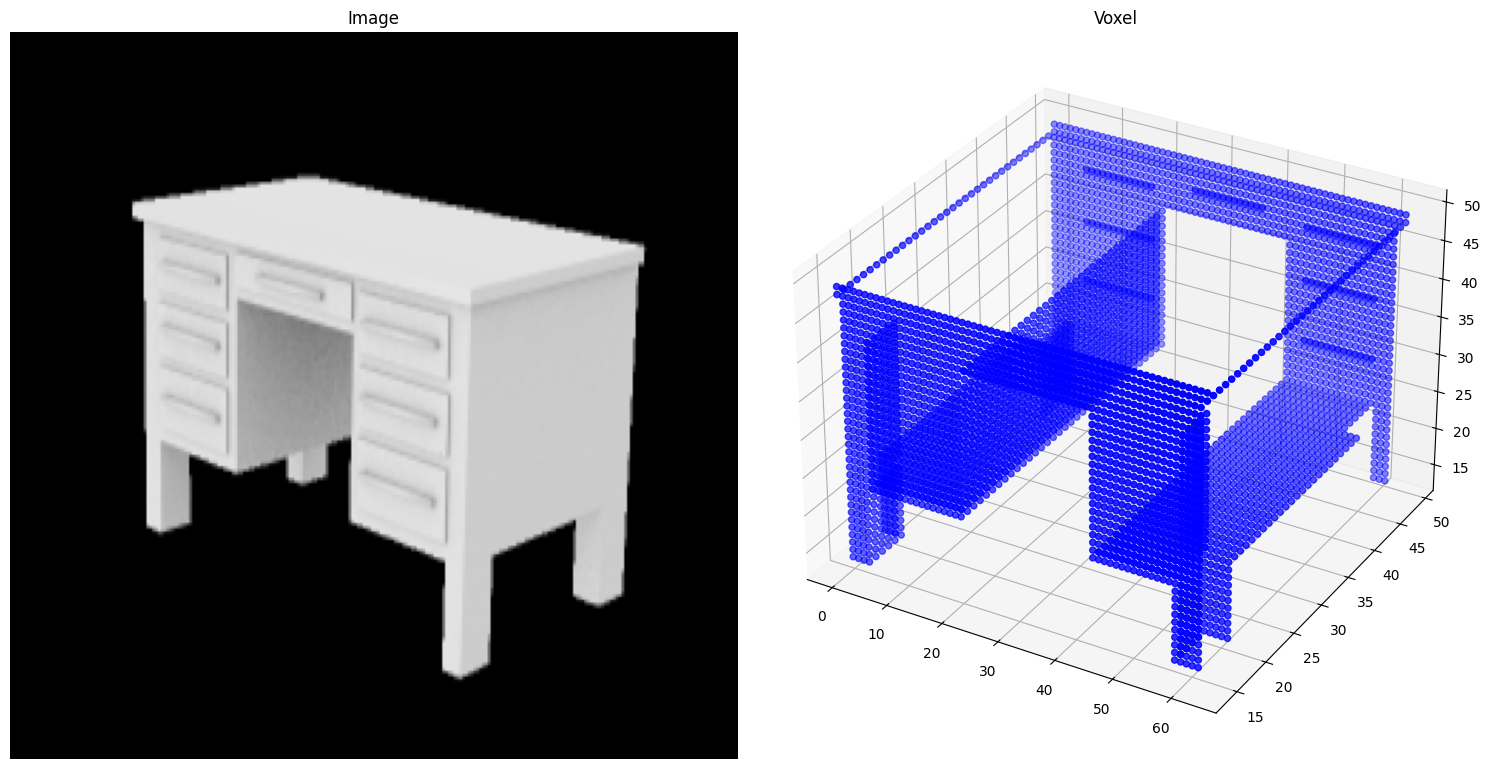

In [ ]:
from memory_profiler import profile
import os
import numpy as np
import cv2
import scipy.io
import random
import torch
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from skimage.transform import resize 
import numpy as np
from scipy.ndimage import zoom
import torch.nn.functional as F
# Load your voxel data, assuming it's stored in a variable called 'voxel_data'
# voxel_data should have the shape (256, 256, 256)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def collect_voxel(address):
    voxel = scipy.io.loadmat(address)['input']
    # Removing the singleton dimension
    if voxel.ndim == 4 and voxel.shape[0] == 1:
        voxel = voxel.reshape(voxel.shape[1], voxel.shape[2], voxel.shape[3])
    # Resize voxel to (32, 32, 32)
    #voxel_resized = sk_resize(voxel, (32, 32, 32), mode='constant', anti_aliasing=True)
    return voxel_resized


import cv2
import torch
from torch.utils.data import Dataset




class ImageVoxelDataset(Dataset):
    def __init__(self, image_paths, voxel_paths, transform=None):
        self.image_paths = image_paths
        self.voxel_paths = voxel_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths) or idx >= len(self.voxel_paths):
            raise IndexError(f"Index {idx} is out of range. Image paths: {len(self.image_paths)}, Voxel paths: {len(self.voxel_paths)}")

        image_path = self.image_paths[idx]
        voxel_path = self.voxel_paths[idx]

        # Load and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (256, 256))  # Resize to (32, 32)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")# torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Choose the device (GPU if available, otherwise CPU)
        image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1).to(device)  # Move the tensor to the selected device

        ###print("Checking tensor data", image.device)
        #image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)  # Convert to tensor

        # Load and preprocess the voxel data
        voxel = collect_voxel(voxel_path)
        ###print(f"Image shape after transformation1: {image.shape}")  # Add this line
        ###print(f"Voxel shape after transformation1: {voxel.shape}")  # Add this line
        # Define the target size
        target_size =(64, 64, 64)

        """# Calculate the resize factors for each axis
        resize_factors = (
        target_size[0] / voxel.shape[0],
        target_size[1] / voxel.shape[1],
        target_size[2] / voxel.shape[2]
        )
        
        # Use the zoom function to resize the voxel data
        voxel1 = zoom(voxel, resize_factors)
        print("ZOOM IS HERE ||||||||||||||||||")
        print("|||||||||||||||||||",voxel.shape)  
        print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")"""

        data=torch.tensor(voxel).unsqueeze(0).unsqueeze(0).float()
        ###print(data.shape)
        # Use F.interpolate for resizing
        voxel2 = F.interpolate(data, size=target_size, mode='trilinear', align_corners=False)
        # Set a threshold value
        threshold = 0.1 # Adjust this value based on your specific use case

        # Apply threshold to create binary voxel data
        voxel2 = (voxel2 >= threshold)#.float()
      
        """#compare data type voxel  and voxel2
        print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
        print(voxel.shape)
        print(voxel2.shape)
        print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")"""

        voxel = torch.tensor(voxel2, dtype=torch.float32).squeeze().unsqueeze(0).to(device)
       ### print("Checking tensor data", voxel.device)
        #voxel = torch.tensor(voxel, dtype=torch.float32)
        ###print(f"Image shape after transformation2: {image.shape}")  # Add this line
        ###print(f"Voxel shape after transformation2: {voxel.shape}")  # Add this line
        return image, voxel




# Function to find paths
def pathFinder(path, image_count):
    paths = []
    for root, _, files in os.walk(path, topdown=True):
        files.sort()
        for file in files[:image_count]:
            paths.append(os.path.join(root, file))
    return sorted(paths)

# Function to load and preprocess images
def collect_image(address, size=(32, 32)):
    image = cv2.imread(address)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = resize(image, size)
    return image

def collect_voxel(address):
    voxel = scipy.io.loadmat(address)['input']
    # Removing the singleton dimension
    if voxel.ndim == 4 and voxel.shape[0] == 1:
        voxel = voxel.reshape(voxel.shape[1], voxel.shape[2], voxel.shape[3])
    return voxel

# Function to visualize both image and voxel data
def visualize_image_and_voxel(image, voxel_data, ax_img, ax_voxel):
    # Display the image
    ax_img.imshow(image)
    ax_img.set_title("Image")
    ax_img.axis('off')

    # Display the voxel data
    if voxel_data.ndim == 3:
        x, y, z = np.nonzero(voxel_data)
        ax_voxel.scatter(x, y, z, zdir='z', c='blue')
        ax_voxel.set_title("Voxel")
    else:
        ax_voxel.text(2, 2, 2, "Voxel data is not 3D", color='red')

# Function to create data loaders
def create_data_loaders(train_image_paths, train_voxel_paths, val_image_paths, val_voxel_paths, batch_size=1):
    train_dataset = ImageVoxelDataset(train_image_paths, train_voxel_paths)
    val_dataset = ImageVoxelDataset(val_image_paths, val_voxel_paths)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Collecting paths
train_imgs = pathFinder('./train_imgs', 1)
train_voxels = pathFinder('./train_voxels', 12)
val_imgs = pathFinder('./val_imgs', 1)
val_voxels = pathFinder('./val_voxels', 12)




def visualize_image_and_voxel(image, voxel_data, ax_img, ax_voxel):
    # Display the image
    ax_img.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax_img.set_title("Image")
    ax_img.axis('off')

    # Display the voxel data
    if voxel_data.ndim == 3:
        if isinstance(voxel_data, torch.Tensor):
            voxel_data = voxel_data.squeeze().cpu().numpy()
        x, y, z = np.nonzero(voxel_data)
        ax_voxel.scatter(x, y, z, zdir='z', c='blue')
        ax_voxel.set_title("Voxel")
    else:
        ax_voxel.text(2, 2, 2, "Voxel data is not 3D", color='red')

# Select 1 random pair to visualize
num_pairs_to_visualize = 1
selected_pairs = random.sample(list(zip(train_imgs, train_voxels)), num_pairs_to_visualize)
selected_pairs=[('./train_imgs/000012/000.png', './train_voxels/000012/model.mat')]

fig = plt.figure(figsize=(15, 15))

for i, (img_path, voxel_path) in enumerate(selected_pairs, 1):
    # Use ImageVoxelDataset to load and preprocess the image and voxel
    dataset = ImageVoxelDataset([img_path], [voxel_path])
    image, voxel = dataset[0]

    ax_img = fig.add_subplot(num_pairs_to_visualize, 2, 2*i-1)
    ax_voxel = fig.add_subplot(num_pairs_to_visualize, 2, 2*i, projection='3d')

    # Move the voxel tensor to CPU before converting to NumPy array
    visualize_image_and_voxel(image, voxel.squeeze().cpu().numpy(), ax_img, ax_voxel)

plt.tight_layout()
plt.show()


In [ ]:
!pwd

## HELPER FUNC

In [3]:
import torch
import torch.nn as nn

class ResidualConvBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, is_res=True):
        super(ResidualConvBlock2D, self).__init__()
        self.is_res = is_res

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

        if self.is_res and in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, 1, 1, 0)
        else:
            self.residual_conv = None

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
       
        if self.is_res:
            if self.residual_conv is not None:
                identity = self.residual_conv(identity)
            x += identity
        
        return x

In [4]:
class UnetDown2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown2D, self).__init__()
        self.block = nn.Sequential(
            ResidualConvBlock2D(in_channels, out_channels),
            ResidualConvBlock2D(out_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        print("Entered UnetDown2D", x.shape)
        x = self.block(x)
        print("UnetDown2D: Return shape", x.shape)
        return x

In [5]:
class ResidualConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, is_res=True):
        super(ResidualConvBlock3D, self).__init__()
        
        # Flag for whether to use a residual connection
        self.is_res = is_res

        # First 3D convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm3d(out_channels),
            nn.GELU()
        )

        # Second 3D convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm3d(out_channels),
            nn.GELU()
        )

        # Residual connection (1x1x1 convolution) for channel dimension alignment, if needed
        self.residual_conv = nn.Conv3d(in_channels, out_channels, 1, stride, 0) if in_channels != out_channels else None

    def forward(self, x):
        print("Entered Residual Conv Block 3D", x.shape)
        # Apply the first convolutional layer
        residual = x
        x = self.conv1(x)
        print("ResidualConvBlock3D: Conv1 shape", x.shape)
        # Apply the second convolutional layer
        x = self.conv2(x)
        print("ResidualConvBlock3D: Conv2 shape", x.shape)

        # Add the residual connection if applicable
        if self.is_res:
            if self.residual_conv is not None:
                residual = self.residual_conv(residual)
            x += residual

        print("ResidualConvBlock3D: Residual Return shape", x.shape)
        return x

In [6]:
class UnetDown3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown3D, self).__init__()
        self.res_block1 = ResidualConvBlock3D(in_channels, out_channels)
        self.res_block2 = ResidualConvBlock3D(out_channels, out_channels)
        self.maxpool = nn.MaxPool3d(2)

    def forward(self, x):
        print("Entered UnetDown3D", x.shape)
        x = self.res_block1(x)
        print("UnetDown3D: ResBlock1 shape", x.shape)
        x = self.res_block2(x)
        print("UnetDown3D: ResBlock2 shape", x.shape)
        x = self.maxpool(x)
        print("UnetDown3D: MaxPool shape", x.shape)
        return x

In [7]:
class UnetUp3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp3D, self).__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.res_block1 = ResidualConvBlock3D(in_channels + out_channels, out_channels*2)  # Adjusted in_channels
        self.res_block2 = ResidualConvBlock3D(out_channels*2, out_channels)

    def forward(self, x, skip_connection):
        print("Entered UnetUp3D", x.shape, skip_connection.shape)
        
        if x.shape != skip_connection.shape:
            raise ValueError("Input size does not match skip connection size. which are: ",x.shape, skip_connection.shape)


        # Resize x to match the size of skip_connection
        
        print(f"Concatinate this is input {x.shape} and this is skip connection{skip_connection.shape}")
        x = self.up(x)
        print("UnetUp3D: Up shape", x.shape)
        if x.size(2) != skip_connection.size(2) or x.size(3) != skip_connection.size(3) or x.size(4) != skip_connection.size(4):
            x = F.interpolate(x, size=(skip_connection.size(2), skip_connection.size(3), skip_connection.size(4)), mode='trilinear', align_corners=True)
            print("Shape Adjusted after upsampling for concatination.")        
        
        
        print(f"Concatinate this is input {x.shape} and this is skip connection{skip_connection.shape}")
        x = torch.cat([x, skip_connection], dim=1).to(device)
        print("UnetUp3D: Cat shape", x.shape)
        x = self.res_block1(x)
        print("UnetUp3D: ResBlock1 shape", x.shape)
        x = self.res_block2(x)
        print("UnetUp3D: ResBlock2 shape", x.shape)
        return x

In [8]:
def add_diagnostic_prints(network,check_conv_2d=True):
    class DiagnosticModule(nn.Module):
        def __init__(self, module, name,check_conv_2d):
            super().__init__()
            self.module = module
            self.name = name
            self.check_conv_2d=check_conv_2d

        def forward(self, x):
            if check_conv_2d:
                print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
                print(f">>>>Entering Diagnostic layer {self.name}: Input shape {x.shape}<<<<")
                x = self.module(x)
                print(f">>>>Exiting Diagnostic layer {self.name}: Output shape {x.shape}<<<<")
                print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
            return x

    def wrap_modules(module,check_conv_2d, prefix=""):
        for name, submodule in module.named_children():
            full_name = f"{prefix}.{name}" if prefix else name
            if isinstance(submodule, nn.Conv2d):  # Corrected this line
                setattr(module, name, DiagnosticModule(submodule, full_name,check_conv_2d))
            else:
                wrap_modules(submodule, full_name)

    wrap_modules(network,check_conv_2d)
    return network

In [10]:


class EmbedFC_voxel(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC_voxel, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim
        
        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        
        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

# MAIN CODE

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class Reverse3D(nn.Module):
    def __init__(self, input_size_image=256,input_size_voxel=64,image_channels=3,voxel_channels=1,n_feat_2d=8,n_feat_3d=32):
        super(Reverse3D, self).__init__()
        self.n_feat_3d=n_feat_3d
        self.voxel_channels=voxel_channels
        self.input_size_image=input_size_image
        self.image_channels=image_channels
        self.n_feat_2d=n_feat_2d

        #Initialize layers for 2D image data
        self.init_conv_image=ResidualConvBlock2D(image_channels,n_feat_2d)
        self.image_down1=UnetDown2D(n_feat_2d,n_feat_2d)
        self.image_down2=UnetDown2D(n_feat_2d,2*n_feat_2d)
        self.image_down3=UnetDown2D(2*n_feat_2d,4*n_feat_2d)
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())
        self.inflate_to_vec_img=nn.Sequential(

            nn.ConvTranspose3d(8, 16, kernel_size=1, stride=1, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
            
        )
        self.time_embed1=EmbedFC_voxel(1,4*n_feat_3d)
        self.time_embed2=EmbedFC_voxel(1,2*n_feat_3d)
        self.time_embed3=EmbedFC_voxel(1,1*n_feat_3d)




        self.init_conv_voxel=ResidualConvBlock3D(voxel_channels,n_feat_3d)
        self.voxel_down1=UnetDown3D(n_feat_3d,n_feat_3d)
        self.voxel_down2=UnetDown3D(n_feat_3d,2*n_feat_3d)
        self.voxel_down3=UnetDown3D(2*n_feat_3d,4*n_feat_3d)
        self.to_vec = nn.Sequential(nn.AvgPool3d((4)), nn.GELU())
        self.inflate_to_vec =  nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=1, stride=1, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
    
                )
        self.up0 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
            nn.ConvTranspose3d(16, 8, kernel_size=1, stride=1, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(8, 4, kernel_size=2, stride=2, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
            nn.ConvTranspose3d(4, 2, kernel_size=1, stride=1, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose3d(2, 1, kernel_size=2, stride=2, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
            nn.ConvTranspose3d(1, 1, kernel_size=1, stride=1, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
        )
        self.up3= nn.Sequential(
            nn.ConvTranspose3d(2, 1, kernel_size=2, stride=2, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
            nn.ConvTranspose3d(1, 1, kernel_size=1, stride=1, padding=0),  # Adjust parameters as needed
            nn.ReLU(),
        )
        
        
    def forward(self,image,voxel,t):
        print(image.shape)
        x_image=self.init_conv_image(image)
        print("X_IMAGE SHAPE:***********************************************",x_image.shape,x_image.shape[1]*x_image.shape[2]*x_image.shape[3])
        image_down1=self.image_down1(x_image)
        print("IMAGE_DOWN1 SHAPE:***********************************************",image_down1.shape,image_down1.shape[1]*image_down1.shape[2]*image_down1.shape[3])
        image_down2=self.image_down2(image_down1)
        print("IMAGE_DOWN2 SHAPE***********************************************",image_down2.shape,image_down2.shape[1]*image_down2.shape[2]*image_down2.shape[3])
        image_down3=self.image_down3(image_down2)
        print("IMAGE_DOWN3 SHAPE:***********************************************",image_down3.shape,image_down3.shape[1]*image_down3.shape[2]*image_down3.shape[3])
        hiddenvec_img = self.to_vec(image_down3)
        print("hiddenvec_img SHAPE:***********************************************",hiddenvec_img.shape,hiddenvec_img.shape[1]*hiddenvec_img.shape[2]*hiddenvec_img.shape[3])
        hiddenvec_img_3d=hiddenvec_img.unsqueeze(1).view(hiddenvec_img.shape[0],8, 4, 4, 4)
        print("hiddenvec_img_3d SHAPE:***********************************************",hiddenvec_img_3d.shape,hiddenvec_img_3d.shape[1]*hiddenvec_img_3d.shape[2]*hiddenvec_img_3d.shape[3]*hiddenvec_img_3d.shape[4])
        hiddenvec_img_3d_inflated=self.inflate_to_vec_img(hiddenvec_img_3d)
        print("hiddenvec_img_3d_inflated:*********************************************",hiddenvec_img_3d_inflated.shape,hiddenvec_img_3d_inflated.shape[1]*hiddenvec_img_3d_inflated.shape[2]*hiddenvec_img_3d_inflated.shape[3]*hiddenvec_img_3d_inflated.shape[4])
        
        time_embed1=self.time_embed1(t).view(-1, self.n_feat_3d * 4, 1, 1)
        time_embed2=self.time_embed2(t).view(-1, self.n_feat_3d * 2, 1, 1)
        time_embed3=self.time_embed3(t).view(-1, self.n_feat_3d * 1, 1, 1)
        print("TIME EMBED SHAPE:***********************************************",time_embed1.shape,time_embed1.shape[1]*time_embed1.shape[2]*time_embed1.shape[3])
        print("TIME EMBED SHAPE:***********************************************",time_embed2.shape,time_embed2.shape[1]*time_embed2.shape[2]*time_embed2.shape[3])
        print("TIME EMBED SHAPE:***********************************************",time_embed3.shape,time_embed3.shape[1]*time_embed3.shape[2]*time_embed3.shape[3])



        x_voxel =self.init_conv_voxel(voxel)
        print("X_VOXEL SHAPE:***********************************************",x_voxel.shape,x_voxel.shape[1]*x_voxel.shape[2]*x_voxel.shape[3]*x_voxel.shape[4])
        vox_down1=self.voxel_down1(x_voxel)
        print("VOX_DOWN1 SHAPE:***********************************************",vox_down1.shape,vox_down1.shape[1]*vox_down1.shape[2]*vox_down1.shape[3]*vox_down1.shape[4])
        vox_down2=self.voxel_down2(vox_down1)
        print("VOX_DOWN2 SHAPE:***********************************************",vox_down2.shape,vox_down2.shape[1]*vox_down2.shape[2]*vox_down2.shape[3]*vox_down2.shape[4])
        
        vox_down3=self.voxel_down3(vox_down2)
        print("VOX_DOWN3 SHAPE:***********************************************",vox_down3.shape,vox_down3.shape[1]*vox_down3.shape[2]*vox_down3.shape[3]*vox_down3.shape[4])
        hiddenvec_vox = self.to_vec(vox_down3)
        print("hiddenvec_vox SHAPE:***********************************************",hiddenvec_vox.shape,hiddenvec_vox.shape[1]*hiddenvec_vox.shape[2]*hiddenvec_vox.shape[3]*hiddenvec_vox.shape[4])
        inflated_hidden_vec= hiddenvec_vox.view(hiddenvec_vox.shape[0],16,4,4,4)
        print("Inflated_hidden_vec Shape:*****************************************",inflated_hidden_vec.shape,inflated_hidden_vec.shape[1]*inflated_hidden_vec.shape[2]*inflated_hidden_vec.shape[3]*inflated_hidden_vec.shape[4])
        combined_tensor =torch.cat((inflated_hidden_vec,hiddenvec_img_3d_inflated),1)#inflated_hidden_vec+hiddenvec_img_3d_inflated
        print("Combined_tensor shape:*****************************************",combined_tensor.shape,combined_tensor.shape[1]*combined_tensor.shape[2]*combined_tensor.shape[3]*combined_tensor.shape[4])
        up0=self.up0(combined_tensor)
        print("up0 shape:*****************************************",up0.shape,up0.shape[1]*up0.shape[2]*up0.shape[3]*up0.shape[4])
        up1=self.up1(up0)
        print("up1 shape:*****************************************",up1.shape,up1.shape[1]*up1.shape[2]*up1.shape[3]*up1.shape[4])
        up2=self.up2(up1)
        print("up2 shape:*****************************************",up2.shape,up2.shape[1]*up2.shape[2]*up2.shape[3]*up2.shape[4])
        resup2=(up2+image_down3.unsqueeze(1)).to(device)
        print("resup2 shape:*****************************************",resup2.shape,resup2.shape[1]*resup2.shape[2]*resup2.shape[3]*resup2.shape[4])
        inflate_resup=torch.cat([resup2,resup2],1)
        print("inflate_resup= *****************************************",inflate_resup.shape,inflate_resup.shape[1]*inflate_resup.shape[2]*inflate_resup.shape[3]*inflate_resup.shape[4])
        up3=self.up3(inflate_resup)
        print("up3 shape:*****************************************",up3.shape,up3.shape[1]*up3.shape[2]*up3.shape[3]*up3.shape[4])
        #resup3=up3+vox_down3.unsqueeze(1)
        #print("resup3 shape:*****************************************",resup3.shape,resup3.shape[1]*resup3.shape[2]*resup3.shape[3]*resup3.shape[4])
        
        output=up3
        print("OUTPUT SHAPE:***********************************************",output.shape,output.shape[1]*output.shape[2]*output.shape[3]*output.shape[4])
        

        
       
        
        
        
        return output

In [12]:
model=Reverse3D()
model=add_diagnostic_prints(model,True)
#print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Reverse3D(
  (init_conv_image): ResidualConvBlock2D(
    (conv1): Sequential(
      (0): DiagnosticModule(
        (module): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): DiagnosticModule(
        (module): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (residual_conv): DiagnosticModule(
      (module): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (image_down1): UnetDown2D(
    (block): Sequential(
      (0): ResidualConvBlock2D(
        (conv1): Sequential(
          (0): DiagnosticModule(
            (module): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(8, eps=1e

In [16]:

import torch.optim as optim

# Before creating data loaders, ensure equal size of datasets
min_dataset_size = min(len(train_imgs), len(train_voxels))-1
train_imgs = train_imgs[:min_dataset_size]
train_voxels=train_voxels[:min_dataset_size]
val_imgs = val_imgs[:min_dataset_size]
train_voxels = train_voxels[:min_dataset_size]



# Assuming create_data_loader is a defined function that correctly processes and creates data loaders
train_loader, val_loader = create_data_loaders(train_imgs, train_voxels, val_imgs, val_voxels, batch_size=1)

# Initialize the Adam optimizer with weight decay
#optimizer = optim.Adam(custom_unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Printing summary information (optional)
print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print("Optimizer initialized with learning rate:", 0.001)

Training DataLoader: 2 batches
Validation DataLoader: 2 batches
Optimizer initialized with learning rate: 0.001


# Hyperparameter

In [18]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat_3d = 32 # 64 hidden dimension feature
n_feat_2d = 8
#height = 16 # 16x16 image
save_dir = './model/'

# training hyperparameters
batch_size = 1
n_epoch = 32
lrate=1e-3

In [19]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [20]:


#helber function: for voxel to perturb a voxel in to a specific noise level
def perturb_input_voxel(x, t, noise):
    return ab_t.sqrt()[t, None, None, None, None] * x + (1 - ab_t[t, None, None, None, None]) * noise

###################ASD

# NORMAL TRAINING

In [21]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from memory_profiler import profile
####Hyperparameter
###############################################
learning_rate=lrate
# Logging and Saving Intervals
log_interval = 10   # Log training progress every 10 batches
n_epochs = n_epoch
save_interval = 5  # Save model every 5 epochs
###############################################
# Define the optimizer and loss function
save_dir='./model/'
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


def train_model():
    for epoch in range(n_epochs):
        print(f"EPOCH COUNT: {epoch}")
        
        running_loss = 0.0
        for batch_idx, (image, voxels) in enumerate(train_loader):
            optimizer.zero_grad()
            print(f"Batch {batch_idx} - Image shape: {image.shape}, Voxel shape: {voxels.shape}")
            voxels, images = voxels.to(device), image.to(device)
            
            noise = torch.randn_like(voxels)
            t = torch.randint(1, timesteps + 1, (voxels.size(0),)).long().to(device)

            voxel_pert = perturb_input_voxel(voxels, t, noise)
            pred_noise = model(image, voxel_pert, t / timesteps)
            loss = F.mse_loss(pred_noise, noise)
            loss.backward()
            optimizer.step()

        # Save model periodically
        if epoch % 5 == 0 or epoch == int(n_epochs - 1):
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            torch.save(model.state_dict(), save_dir + f"model_{epoch}.pth")
            print('saved model at ' + save_dir + f"model_{epoch}.pth")

    torch.save(model.state_dict(), "model/model.pth")
    print(">>>>>Model saved! Training Complete<<<<<")



train_model()


EPOCH COUNT: 0
Batch 0 - Image shape: torch.Size([1, 3, 256, 256]), Voxel shape: torch.Size([1, 1, 64, 64, 64])
torch.Size([1, 3, 256, 256])
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
>>>>Entering Diagnostic layer 0: Input shape torch.Size([1, 3, 256, 256])<<<<


/tmp/ipykernel_2946092/4062537850.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel2, dtype=torch.float32).squeeze().unsqueeze(0).to(device)


>>>>Exiting Diagnostic layer 0: Output shape torch.Size([1, 8, 256, 256])<<<<
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
>>>>Entering Diagnostic layer 0: Input shape torch.Size([1, 8, 256, 256])<<<<
>>>>Exiting Diagnostic layer 0: Output shape torch.Size([1, 8, 256, 256])<<<<
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
>>>>Entering Diagnostic layer residual_conv: Input shape torch.Size([1, 3, 256, 256])<<<<
>>>>Exiting Diagnostic layer residual_conv: Output shape torch.Size([1, 8, 256, 256])<<<<
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
X_IMAGE SHAPE:*********************************************** torch.Size([1, 8, 256, 256]) 524288
Entered UnetDown2D torch.Size([1, 8, 256, 256])
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
>>>>Entering Diagnostic layer 0: Input shape torch

# DENOISE ADD NOISE

In [32]:

#helper function; removes the predicted noise from a voxel (but adds some noise back to the voxel to avoid collapse)
def denoise_add_noise_voxel(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise



In [33]:

@torch.no_grad()
def voxel_sample_ddpm(image):
    voxel=torch.randn(1,1,64,64,64).to(device)
    

    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        #reshape time tensor
        t = torch.tensor([i/timesteps])[:,None,None,None,None].to(device)

        #sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(voxel) if i > 1 else 0

        eps = model(image,voxel,t)
        samples = denoise_add_noise_voxel(voxel, i, eps, z)
        return samples





In [34]:
# load in model weights and set to eval mode
model.load_state_dict(torch.load(f"{save_dir}/model.pth", map_location=device))
model.eval()
print("Loaded in Model")

Loaded in Model


/tmp/ipykernel_2946092/4062537850.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel2, dtype=torch.float32).squeeze().unsqueeze(0).to(device)


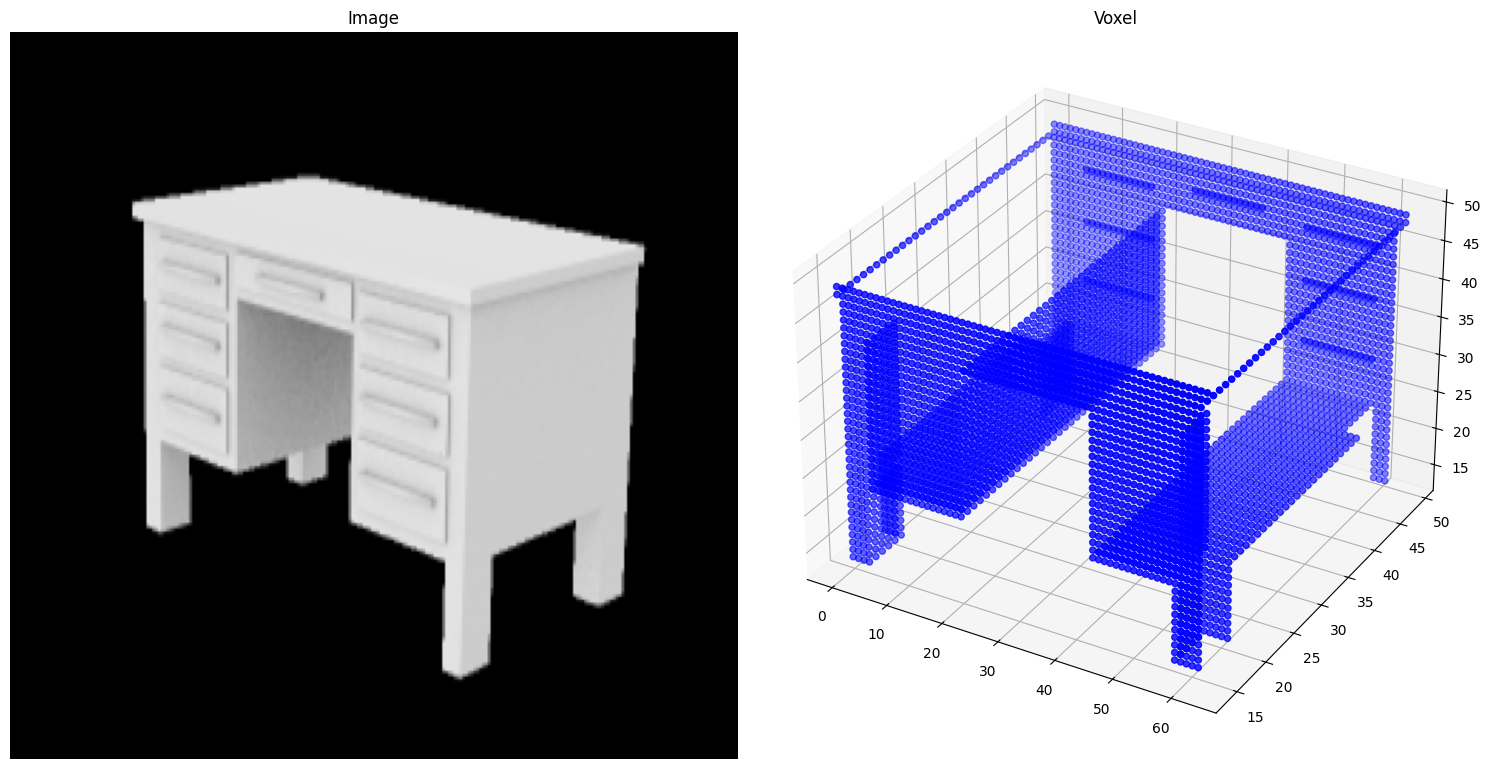

In [35]:
selected_pairs=[('./train_imgs/000012/000.png', './train_voxels/000012/model.mat')]

fig = plt.figure(figsize=(15, 15))

for i, (img_path, voxel_path) in enumerate(selected_pairs, 1):
    # Use ImageVoxelDataset to load and preprocess the image and voxel
    dataset = ImageVoxelDataset([img_path], [voxel_path])
    image, voxel = dataset[0]

    ax_img = fig.add_subplot(num_pairs_to_visualize, 2, 2*i-1)
    ax_voxel = fig.add_subplot(num_pairs_to_visualize, 2, 2*i, projection='3d')

    # Move the voxel tensor to CPU before converting to NumPy array
    visualize_image_and_voxel(image, voxel.squeeze().cpu().numpy(), ax_img, ax_voxel)

plt.tight_layout()
plt.show()

In [36]:
dataset = ImageVoxelDataset([img_path], [voxel_path])
image, voxel = dataset[0]

/tmp/ipykernel_2946092/4062537850.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel2, dtype=torch.float32).squeeze().unsqueeze(0).to(device)


In [37]:
print(image.shape)
print(voxel.shape)

torch.Size([3, 256, 256])
torch.Size([1, 64, 64, 64])


In [38]:
sample=voxel_sample_ddpm(image.unsqueeze(0))

torch.Size([1, 3, 256, 256])
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
>>>>Entering Diagnostic layer 0: Input shape torch.Size([1, 3, 256, 256])<<<<
>>>>Exiting Diagnostic layer 0: Output shape torch.Size([1, 8, 256, 256])<<<<
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
>>>>Entering Diagnostic layer 0: Input shape torch.Size([1, 8, 256, 256])<<<<
>>>>Exiting Diagnostic layer 0: Output shape torch.Size([1, 8, 256, 256])<<<<
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
>>>>Entering Diagnostic layer residual_conv: Input shape torch.Size([1, 3, 256, 256])<<<<
>>>>Exiting Diagnostic layer residual_conv: Output shape torch.Size([1, 8, 256, 256])<<<<
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
X_IMAGE SHAPE:*********************************************** torch.Size([1, 8, 256, 256]

In [39]:
vox=sample.squeeze().unsqueeze(0)
print(vox.shape)

torch.Size([1, 64, 64, 64])


/tmp/ipykernel_2946092/4062537850.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel2, dtype=torch.float32).squeeze().unsqueeze(0).to(device)


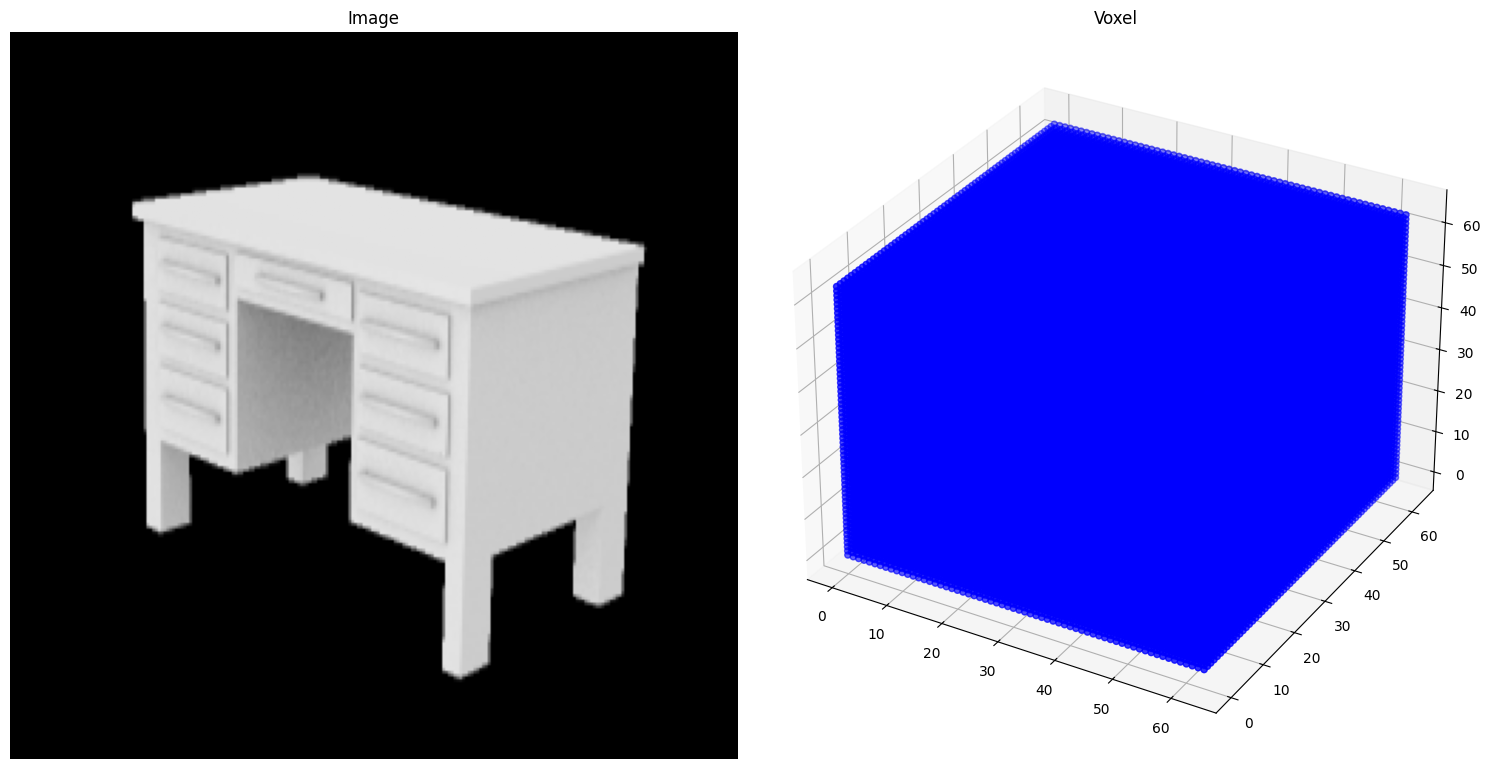

In [40]:
selected_pairs=[('./train_imgs/000012/000.png', './train_voxels/000012/model.mat')]

fig = plt.figure(figsize=(15, 15))

for i, (img_path, voxel_path) in enumerate(selected_pairs, 1):
    # Use ImageVoxelDataset to load and preprocess the image and voxel
    dataset = ImageVoxelDataset([img_path], [voxel_path])
    image, voxel = dataset[0]
    voxel=vox
    ax_img = fig.add_subplot(num_pairs_to_visualize, 2, 2*i-1)
    ax_voxel = fig.add_subplot(num_pairs_to_visualize, 2, 2*i, projection='3d')

    # Move the voxel tensor to CPU before converting to NumPy array
    visualize_image_and_voxel(image, voxel.squeeze().cpu().numpy(), ax_img, ax_voxel)

plt.tight_layout()
plt.show()

# TRAINING + VALIDATION

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import os

#### Hyperparameter
learning_rate = 0.001
# Logging and Saving Intervals
log_interval = 10  # Log training progress every 10 batches
n_epochs = 2
# Define the optimizer and loss function
save_dir = './model/'
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

def train_model():
    for epoch in range(n_epochs):
        print(f"EPOCH COUNT: {epoch}")

        running_loss = 0.0
        for batch_idx, (image, voxels) in enumerate(train_loader):
            optimizer.zero_grad()
            print(f"Batch {batch_idx} - Image shape: {image.shape}, Voxel shape: {voxels.shape}")
            voxels, images = voxels.to(device), image.to(device)

            noise = torch.randn_like(voxels)
            t = torch.randint(1, timesteps + 1, (voxels.size(0),)).long().to(device)

            voxel_pert = perturb_input_voxel(voxels, t, noise)
            pred_noise = model(image, voxel_pert, t / timesteps)
            loss = F.mse_loss(pred_noise, noise)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % log_interval == log_interval - 1:
                print(f"Epoch {epoch} - Batch {batch_idx} - Loss: {running_loss / log_interval}")
                running_loss = 0.0

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_batch_idx, (val_image, val_voxels) in enumerate(val_loader):
                val_voxels, val_images = val_voxels.to(device), val_image.to(device)
                val_outputs = model(val_image, val_voxels)
                val_loss += criterion(val_outputs, val_voxels)

            print(f"Epoch {epoch} - Validation Loss: {val_loss / len(val_loader)}")

        print(f"Validation Loss after Epoch {epoch + 1}: {val_loss / len(val_loader):.4f}")

        # Save model periodically
        if epoch % 5 == 0 or epoch == int(n_epochs - 1):
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            torch.save(model.state_dict(), save_dir + f"model_{epoch}.pth")
            print('saved model at ' + save_dir + f"model_{epoch}.pth")

    torch.save(model.state_dict(), "model/model.pth")
    print(">>>>>Model saved! Training Complete<<<<<")

train_model()


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from memory_profiler import profile
####Hyperparameter
###############################################
learning_rate=0.001
# Logging and Saving Intervals
log_interval = 10   # Log training progress every 10 batches
n_epochs = 2
# Define the optimizer and loss function
save_dir='./model/'
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()  # Or any other appropriate loss function

#out_out=torch.randint(0,8,(1,16,16,16)).float().to(device)
#out_out_voxel=torch.randint(0,8,(1,64,4,4,4)).float().to(device)
#print("out_out shape",out_out.shape)
#print("out_out_voxel shape",out_out_voxel.shape)

#@profile
def train_model():
    for epoch in range(n_epochs):
        print(f"EPOCH COUNT: {epoch}")
        
        running_loss = 0.0
        for batch_idx,(image,voxels) in enumerate(train_loader):
            optim.zero_grad()
            print(f"Batch {batch_idx} - Image shape: {image.shape}, Voxel shape: {voxels.shape}")
            voxels,images=voxels.to(device),image.to(device)
            
            noise=torch.randn_like(voxels)
            t=torch.randint(1,timestes+1,(voxels.size(0),)).long().to(device)

            voxel_pert=perturb_input_voxel(voxels,t,noise)
            pred_noise=model(image,voxel_pert,t/timesteps)
            loss=F.mse_loss(pred_noise,noise)
            loss.backward()
            optimizer.step()

        

        """# save model periodically
        if ep%4==0 or ep == int(n_epoch-1):
            if not os.path.exists(save_dir):
            os.mkdir(save_dir)
            torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
            print('saved model at ' + save_dir + f"model_{ep}.pth")"""
        #Save model periodically
        if epoch%5==0 or epoch == int(n_epoch-1):
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            torch.save(model.state_dict(), save_dir + f"model_{epoch}.pth")
            print('saved model at ' + save_dir + f"model_{epoch}.pth")
            
        """model.train()
        for batch_idx,(image,voxels) in enumerate(train_loader):
            voxels,images=voxels.to(device),image.to(device)

            #random_timesteps = torch.randint(0, diffusion_timesteps, (voxels.size(0),)).float().to(device)
            optimizer.zero_grad()
            images.shape
            outputs=model(images,voxels)
            loss = criterion(outputs,voxels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()

            if batch_idx% log_interval==log_interval-1:
                print(f"Epoch {epoch} - Batch {batch_idx} - Loss: {running_loss/log_interval}")
                running_loss=0.0

        model.eval()
        val_loss=0.0
        with torch.no_grad():
            for val_batch_idx,(val_image,val_voxels) in enumerate(val_loader):
                val_voxels,val_images=val_voxels.to(device),val_image.to(device)
                val_outputs=model(val_image,val_voxels)
                val_loss+=criterion(val_outputs,val_voxels)#out_out)
            print(f"Epoch {epoch} - Validation Loss: {val_loss/len(val_loader)}")

        print(f"Validation Loss after Epoch {epoch+1}: {val_loss/len(val_loader):.4f}")"""

    torch.save(model.state_dict(), "model/model.pth")
    print(">>>>>Model saved! Training Complete<<<<<")
            


train_model()

########################ASD

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from memory_profiler import profile
####Hyperparameter
###############################################
learning_rate=0.001
# Logging and Saving Intervals
log_interval = 10   # Log training progress every 10 batches
n_epochs = 2
# Define the optimizer and loss function

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()  # Or any other appropriate loss function
out_out=torch.randint(0,8,(1,16,16,16)).float().to(device)
out_out_voxel=torch.randint(0,8,(1,64,4,4,4)).float().to(device)
print("out_out shape",out_out.shape)
print("out_out_voxel shape",out_out_voxel.shape)
#@profile
def train_model():
    for epoch in range(n_epochs):
        print(f"EPOCH COUNT: {epoch}")
        model.train()
        running_loss = 0.0
        for batch_idx,(image,voxels) in enumerate(train_loader):
            print(f"Batch {batch_idx} - Image shape: {image.shape}, Voxel shape: {voxels.shape}")
            voxels,images=voxels.to(device),image.to(device)
            #random_timesteps = torch.randint(0, diffusion_timesteps, (voxels.size(0),)).float().to(device)
            optimizer.zero_grad()
            images.shape
            outputs=model(images,voxels)
            loss = criterion(outputs,voxels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()

            if batch_idx% log_interval==log_interval-1:
                print(f"Epoch {epoch} - Batch {batch_idx} - Loss: {running_loss/log_interval}")
                running_loss=0.0

        model.eval()
        val_loss=0.0
        with torch.no_grad():
            for val_batch_idx,(val_image,val_voxels) in enumerate(val_loader):
                val_voxels,val_images=val_voxels.to(device),val_image.to(device)
                val_outputs=model(val_image,val_voxels)
                val_loss+=criterion(val_outputs,val_voxels)#out_out)
            print(f"Epoch {epoch} - Validation Loss: {val_loss/len(val_loader)}")

        print(f"Validation Loss after Epoch {epoch+1}: {val_loss/len(val_loader):.4f}")

    torch.save(model.state_dict(), "model/model.pth")
    print(">>>>>Model saved! Training Complete<<<<<")
            


train_model()

In [ ]:
model = add_diagnostic_prints(model)

model.to(device)
# Create dummy inputs
image_channels=3
#voxel_input = torch.randn(9, voxel_channels, 32, 32, 32).to(device)  # Example shape
image_input = torch.randn(9, 1,128,128,128).to(device)  # Example shape
t = torch.tensor([0])  # Example tensor for t

# Forward passoutput_voxel, ...............................................................+3
output_image = model( image_input)

In [ ]:
print(output_image.shape)